In [1]:
from multiprocessing import cpu_count
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.transforms.functional as FT
import matplotlib.pyplot as plt

c:\Users\trong\Downloads\honda_spotweld\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
data_root = '/workspace/gan/celeba1'
workers = cpu_count()

In [87]:
def main():
    batch_size = 128
    image_size = 64
    nz = 100
    nc = 3
    n_gen_feat = 64
    n_dis_feat = 64
    epochs = 5
    lr = 1e-5
    beta1 = 0.5
    device = torch.device('cuda:0')

    dataset = dset.ImageFolder(
        root=str(data_root),
        transform=transforms.Compose([
             transforms.Resize(image_size),
             transforms.CenterCrop(image_size),
             transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
         ]))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

    # real_batch = next(iter(data_loader))
    # plt.figure(figsize=(8, 8))
    # plt.axis('off')
    # plt.imshow(
    #     np.transpose(
    #         vutils.make_grid(
    #             real_batch[0].to(device)[:64],
    #             padding=2, normalize=True).cpu(),
    #         (1, 2, 0)))
    # plt.pause(0.0001)

    crit = nn.BCELoss()
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    real_label = 1
    fake_label = 0

    net_g = Generator(nz, n_gen_feat, nc).to(device)
    net_d = Discriminator(n_dis_feat, nc).to(device)

    opt_g = optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))
    opt_d = optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))

    g_losses, d_losses = [], []
    img_list = []
    iters = 0

    print('Starting training loop...')
    for epoch in range(epochs):
        for i, data in enumerate(data_loader, 0):
            net_d.zero_grad()
            real = data[0].to(device)
            b_size = real.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float32, device=device)
            output = net_d(real).view(-1)
            err_d_real = crit(output, label)
            err_d_real.backward()
            d_x = output.mean().item()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = net_g(noise)
            label.fill_(fake_label)
            output = net_d(fake.detach()).view(-1)
            err_d_fake = crit(output, label.to(torch.float32))
            err_d_fake.backward()
            d_g_z1 = output.mean().item()
            err_d = err_d_real + err_d_fake
            opt_d.step()

            net_g.zero_grad()
            label.fill_(real_label)
            output = net_d(fake).view(-1)
            err_g = crit(output, label.to(torch.float32))
            err_g.backward()
            d_g_z2 = output.mean().item()
            opt_g.step()

            if i % 50 == 0:
                print('[%d/%d][%d/%d]\t'
                      'Loss_D: %.4f\t'
                      'Loss_G: %.4f\t'
                      'D(x): %.4f\t'
                      'D(G(z)): %.4f / %.4f'
                      % (epoch, epochs, i, len(data_loader),
                         err_d.item(), err_g.item(), d_x, d_g_z1, d_g_z2))

            g_losses.append(err_g.item())
            d_losses.append(err_d.item())

            if (iters % 500 == 0) or (
                    (epoch == epochs - 1) and (i == len(data_loader) - 1)):
                with torch.no_grad():
                    fake = net_g(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(
                    fake, padding=2, normalize=True))

            iters += 1

    torch.save(net_g.state_dict(), "/workspace/gan/net_g.pt")
    torch.save(net_d.state_dict(), "/workspace/gan/net_d.pt")

In [2]:
class GenBlock(nn.Module):

    def __init__(self, ni, no, kernel, stride, pad, bias=False):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ni, no, kernel, stride, pad, bias=bias)
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [3]:
class Generator(nn.Module):

    def __init__(self, nz, nf, nc):
        super().__init__()
        self.main = nn.Sequential(
            GenBlock(nz,     nf * 8, 4, 1, 0),
            GenBlock(nf * 8, nf * 4, 4, 2, 1),
            GenBlock(nf * 4, nf * 2, 4, 2, 1),
            GenBlock(nf * 2, nf,     4, 2, 1),
            nn.ConvTranspose2d(nf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.apply(init_weights)

    def forward(self, x):
        return self.main(x)

In [4]:
class ConvBlock(nn.Module):

    def __init__(self, ni, no, kernel, stride, pad, alpha=0.2, bias=False):
        super().__init__()
        self.conv = nn.Conv2d(ni, no, kernel, stride, pad, bias=bias)
        self.bn = nn.BatchNorm2d(no)
        self.leaky_relu = nn.LeakyReLU(alpha, True)

    def forward(self, x):
        return self.leaky_relu(self.bn(self.conv(x)))

In [5]:
class Discriminator(nn.Module):

    def __init__(self, nf, nc):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, nf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            ConvBlock(nf,     nf * 2, 4, 2, 1),
            ConvBlock(nf * 2, nf * 4, 4, 2, 1),
            ConvBlock(nf * 4, nf * 8, 4, 2, 1),
            nn.Conv2d(nf * 8, 1,      4, 1, 0),
            nn.Sigmoid()
        )
        self.apply(init_weights)

    def forward(self, x):
        return self.main(x)

In [6]:
def init_weights(m):
    class_name = m.__class__.__name__
    if class_name in ('ConvBlock', 'GenBlock'):
        for child in m.children():
            init_weights(child)
    elif class_name.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif class_name.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
#train
main()

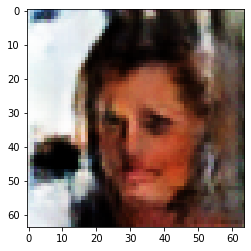

In [7]:
nz = 100
nc = 3
n_gen_feat = 64
net_g = Generator(nz, n_gen_feat, nc)
net_g.load_state_dict(torch.load("./net_g.pt", map_location="cpu"))

fixed_noise = torch.randn(1, nz, 1, 1)
fake = net_g(fixed_noise).squeeze(0)
fake = fake*0.5 +0.5
fake = fake*255
fake = fake.permute(1, 2, 0)
img = fake.detach().numpy()
img=img.astype('uint8')
#PIL_image = Image.fromarray(img.astype('uint8'), 'RGB')
img = FT.to_pil_image(img)
plt.imshow(img)
#plt.savefig(".\\foo.jpg")
a=0